In [1]:
#@title Import necessary packages and set correct device

import os

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage import io
from skimage.measure import regionprops
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.util import img_as_float
from torch.utils.data import random_split

from modules.refcocog import RefCOCOg, RefCOCOgSample

if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA GPU
    print("[INFO] GPU found, using GPU.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] GPU found, using GPU.


In [2]:
#@title Import RefCOCOg dataset and its train/val/test splits

dataset_path = "/media/dmmp/vid+backup/Data/refcocog"

dataset = RefCOCOg(ds_path=dataset_path)

train_ds = RefCOCOg(ds_path=dataset_path, split='train')
val_ds = RefCOCOg(ds_path=dataset_path, split='val')
test_ds = RefCOCOg(ds_path=dataset_path, split='test')

# keep only a toy portion of each split
keep = 0.1
train_ds, _ = random_split(train_ds, [int(keep * len(train_ds)), len(train_ds) - int(keep * len(train_ds))])
val_ds, _ = random_split(val_ds, [int(keep * len(val_ds)), len(val_ds) - int(keep * len(val_ds))])
test_ds, _ = random_split(test_ds, [int(keep * len(test_ds)), len(test_ds) - int(keep * len(test_ds))])

print(f"Dataset Size: {len(dataset)}\n")
print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Dataset Size: 49822

Train size: 4222
Val size:   257
Test size:  502


In [3]:
#@title Import CLIP model

clip_model, clip_prep = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [03:53<00:00, 1.51MiB/s]


In [4]:
#@title Utility function to display image and its regions colored according to CLIP scores

def display_slic_heatmap(image, segments, scores, prompt, colormap="viridis"):

    scores = (scores - scores.min()) / (scores.max() - scores.min())

    cmap = plt.colormaps[colormap]

    mask_image = np.zeros_like(image)

    for i in np.unique(segments):
        color = tuple([c*255 for c in cmap(scores[i-1])[:3]])
        mask = segments == i
        mask_image[mask] = color

    # create two axes
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    ax[0].imshow(image)
    ax[0].imshow(mask_image, alpha=0.75)

    ax[1].imshow(image)

    ax[0].axis("off")
    ax[1].axis("off")

    plt.title(f"\"{prompt.capitalize()}\"\n")

    plt.show()


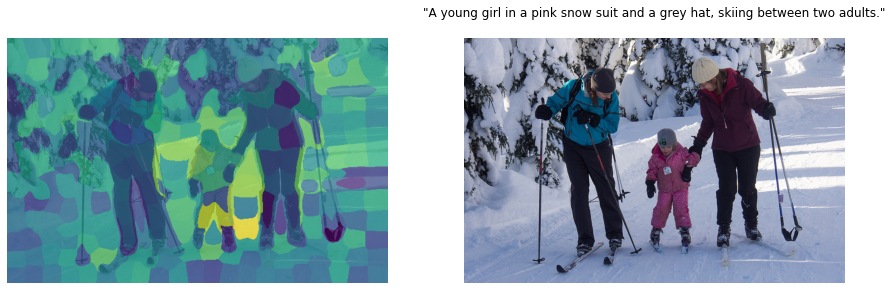

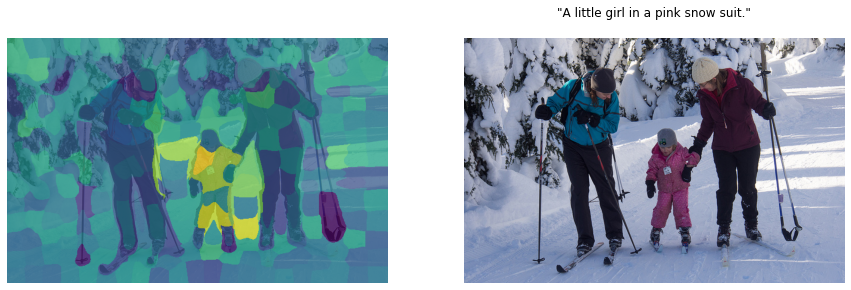

Using cache found in /home/dmmp/.cache/torch/hub/ultralytics_yolov5_master


requirements: /home/dmmp/.cache/torch/hub/requirements.txt not found, check failed.


Exception: Invalid CUDA '--device cuda' requested, use '--device cpu' or pass valid CUDA device(s). Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

In [6]:
#title Apply SLIC segmentation and compute CLIP scores for each region

%matplotlib inline

idx = np.random.randint(0, len(dataset))
superpixels = 300

sample = RefCOCOgSample(**dataset[idx])

np_image = img_as_float(io.imread(sample.path))

for sentence in sample.sentences:

    segments = slic(np_image, n_segments=superpixels, sigma=5)
    regions = regionprops(segments)

    prompt_tkn = clip.tokenize(sentence).to(device)

    with torch.no_grad():
        prompt_enc = clip_model.encode_text(prompt_tkn)

    images_encs = list()

    for region in regions:

        rect = region.bbox
        rect = (rect[1], rect[0], rect[3], rect[2])

        sub_image = sample.img.crop(rect)
        sub_image = clip_prep(sub_image).unsqueeze(0)
        sub_image = sub_image.to(device)

        with torch.no_grad():
            image_enc = clip_model.encode_image(sub_image)

        images_encs.append(image_enc)

    images_encs = torch.cat(images_encs, dim=0)

    hmap = prompt_enc @ images_encs.T
    
    hmap = hmap.cpu()

    hmap = hmap.squeeze().numpy()

    display_slic_heatmap(sample.img, segments, hmap, sentence)

### Comparison with yoloclip, just curious...

from modules.yoloclip import YoloClip

if "yoloclip" not in locals():
    yoloclip = YoloClip(device=device, quiet=True, categories=dataset.categories)

sample = RefCOCOgSample(**dataset[idx])

for sentence in sample.sentences:
    yoloclip(sample, sentence, show=True)
